# Data Transformation by Encoding

> Hands‑on demo to accompany the slide **‘Data Transformation by Encoding’**.

**What you will learn**
- Why categorical variables must be encoded for ML
- Differences between **label/ordinal encoding** and **one‑hot encoding**
- How to pick the right encoder for **ordered vs. unordered** categories
- How to handle **unseen categories** and **high‑cardinality** features
- How to use `ColumnTransformer`/`Pipeline` to encode multiple columns safely


## 0. Setup (packages)
Run this once in VS Code to install dependencies. It’s safe to re‑run.

In [ ]:
#%pip -q install numpy pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Imports & reproducibility

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

np.random.seed(42)
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (9,4)

## 2. Concept — Why encoding?
Machine learning models need **numbers**, not raw text. Encoding converts categories like `Red`, `Green`, `Blue` or `Yes/No` into numeric representations that algorithms can use.

**Two common approaches**
- **Label/Ordinal encoding**: map each category to an integer (e.g., `{Small:0, Medium:1, Large:2}`). Good for **ordered** categories. Risky for **unordered** categories because models may think 2>1>0 implies a distance/order.
- **One‑hot encoding**: create one binary column per category (e.g., `color_Red`, `color_Blue`, …). Good for **unordered** categories; avoids fake ordering.

## 3. Create a toy dataset (categoricals + one numeric)
We’ll build a small dataset that includes:
- `size` (ordered: Small < Medium < Large)
- `color` (unordered: Red, Green, Blue, Yellow)
- `is_member` (Yes/No)
- `city` (higher cardinality; we’ll handle later)
- `spend` (numeric target for classification: high/low based on threshold)


In [3]:
sizes = np.random.choice(['Small','Medium','Large'], size=240, p=[0.4,0.4,0.2])
colors = np.random.choice(['Red','Green','Blue','Yellow'], size=240)
is_member = np.random.choice(['Yes','No'], size=240, p=[0.55,0.45])
cities = np.random.choice([f'City_{i:02d}' for i in range(1,21)], size=240)  # 20 categories
# generate spend with simple effects: members spend more; Large size slightly more
base = np.random.normal(50, 10, size=240)
bonus_member = (is_member=='Yes')*12
bonus_size = pd.Series(sizes).map({'Small':-2,'Medium':2,'Large':5}).values
spend_cont = base + bonus_member + bonus_size
spend = (spend_cont > np.percentile(spend_cont, 55)).astype(int)  # 1 = high spender
df = pd.DataFrame({'size':sizes,'color':colors,'is_member':is_member,'city':cities,'spend_high':spend})
df.head()

,size,color,is_member,city,spend_high
0,Small,Yellow,Yes,City_05,0
1,Large,Green,No,City_18,1
2,Medium,Red,Yes,City_10,1
3,Medium,Green,Yes,City_06,1
4,Small,Red,No,City_01,0


## 4. Ordinal (label) encoding for **ordered** categories
We’ll encode `size` with a **meaningful order**: Small < Medium < Large.

In [4]:
size_order = [['Small','Medium','Large']]  # nested list per column
ord_enc = OrdinalEncoder(categories=size_order)
df['size_ord'] = ord_enc.fit_transform(df[['size']])
df[['size','size_ord']].head(10)

,size,size_ord
0,Small,0.0
1,Large,2.0
2,Medium,1.0
3,Medium,1.0
4,Small,0.0
5,Small,0.0
6,Small,0.0
7,Large,2.0
8,Medium,1.0
9,Medium,1.0


## 5. One‑Hot encoding for **unordered** categories
We’ll one‑hot encode `color` and `is_member`. We’ll drop nothing for clarity (keep all dummies).

In [6]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # NEW
ohe_cols = ['color', 'is_member']
ohe_arr = ohe.fit_transform(df[ohe_cols])     # returns a dense ndarray because sparse_output=False
ohe_feature_names = ohe.get_feature_names_out(ohe_cols)

df_ohe = pd.DataFrame(ohe_arr, columns=ohe_feature_names, index=df.index)
df2 = pd.concat([df, df_ohe], axis=1)
df2.head()

,size,color,is_member,city,spend_high,size_ord,color_Blue,color_Green,color_Red,color_Yellow,is_member_No,is_member_Yes
0,Small,Yellow,Yes,City_05,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,Large,Green,No,City_18,1,2.0,0.0,1.0,0.0,0.0,1.0,0.0
2,Medium,Red,Yes,City_10,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,Medium,Green,Yes,City_06,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,Small,Red,No,City_01,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### Visual: category counts (before encoding)

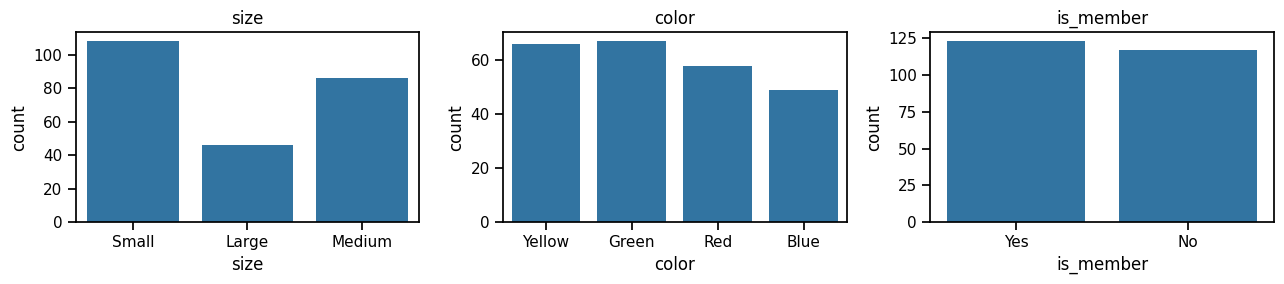

In [7]:
fig, axes = plt.subplots(1,3, figsize=(13,3))
sns.countplot(x='size', data=df, ax=axes[0]); axes[0].set_title('size')
sns.countplot(x='color', data=df, ax=axes[1]); axes[1].set_title('color')
sns.countplot(x='is_member', data=df, ax=axes[2]); axes[2].set_title('is_member')
plt.tight_layout(); plt.show()

## 6. Why label‑encoding unordered categories can mislead linear models
Below we intentionally (and incorrectly) apply ordinal encoding to `color`. A linear model may treat `Blue=0, Green=1, Red=2, Yellow=3` as **ordered distances**, which is not meaningful. We compare this to one‑hot encoding.

In [8]:
# Incorrect: impose arbitrary order on color
ord_colors = OrdinalEncoder()
X_bad = pd.DataFrame({
    'size_ord': df2['size_ord'],
    'color_ord': ord_colors.fit_transform(df[['color']]).ravel(),
    'is_member_ord': OrdinalEncoder().fit_transform(df[['is_member']]).ravel(),
})
y = df['spend_high']
X_train_b, X_test_b, y_train, y_test = train_test_split(X_bad, y, test_size=0.25, random_state=42)
clf_bad = LogisticRegression(max_iter=200).fit(X_train_b, y_train)
bad_score = clf_bad.score(X_test_b, y_test)
# Correct: use one‑hot for unordered columns
ct = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(categories=size_order), ['size']),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ['color','is_member'])
], remainder='drop')
pipe = Pipeline([('prep', ct), ('clf', LogisticRegression(max_iter=200))])
X = df[['size','color','is_member']]
X_train, X_test, y_train2, y_test2 = train_test_split(X, y, test_size=0.25, random_state=42)
pipe.fit(X_train, y_train2)
good_score = pipe.score(X_test, y_test2)
bad_score, good_score

(0.6833333333333333, 0.7166666666666667)

**Interpretation:** Scores may differ because the arbitrary numbers from label encoding can create fake relationships for `color`. One‑hot avoids implying order. (Tree‑based models are less sensitive to this, but linear models and distance‑based models are.)

## 7. Handling unseen categories at inference
Real data often contains categories in test/production that we did **not** see during training. Use `handle_unknown='ignore'` in `OneHotEncoder` and keep the fitted encoder to apply later.

In [9]:
enc = OneHotEncoder(handle_unknown='ignore')
X_train = df[['color','is_member']].iloc[:200]
X_test  = df[['color','is_member']].iloc[200:].copy()
# Introduce an unseen category
X_test.loc[X_test.index[:5], 'color'] = 'Purple'
enc.fit(X_train)
train_mat = enc.transform(X_train)
test_mat  = enc.transform(X_test)  # succeeds because handle_unknown='ignore'
train_mat.shape, test_mat.shape, enc.get_feature_names_out()[:5]


((200, 6),
 (40, 6),
 array(['color_Blue', 'color_Green', 'color_Red', 'color_Yellow',
        'is_member_No'], dtype=object))

## 8. High‑cardinality categories (`city`) — simple strategies
High numbers of categories can explode one‑hot features. Two simple tactics:
1) **Top‑K frequency**: keep the K most common categories, group the rest into `Other`.
2) **Hashing trick (advanced)**: map strings to a fixed number of bins (not shown here).

In [11]:
K = 5
topk = df['city'].value_counts().nlargest(K).index
city_simplified = df['city'].where(df['city'].isin(topk), other='Other')

from sklearn.preprocessing import OneHotEncoder
enc_city = OneHotEncoder(sparse_output=False)  # <-- changed from 'sparse=False'

city_ohe = enc_city.fit_transform(city_simplified.to_frame())
pd.DataFrame(city_ohe, columns=enc_city.get_feature_names_out(['city'])).head()

,city_City_01,city_City_04,city_City_05,city_City_06,city_City_15,city_Other
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


## 9. End‑to‑end preprocessing with `ColumnTransformer` + `Pipeline`
This is the **recommended pattern**: define which columns are ordinal vs. one‑hot, and bundle them with a model.

In [12]:
df3 = df.copy()
df3['city_simple'] = df3['city'].where(df3['city'].isin(topk), other='Other')
X = df3[['size','color','is_member','city_simple']]
y = df3['spend_high']
preprocess = ColumnTransformer(transformers=[
    ('size_ord', OrdinalEncoder(categories=size_order), ['size']),
    ('cat_ohe', OneHotEncoder(handle_unknown='ignore'), ['color','is_member','city_simple'])
])
clf = Pipeline([('prep', preprocess), ('lr', LogisticRegression(max_iter=300))])
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42)
clf.fit(X_tr, y_tr)
clf.score(X_te, y_te)


0.6833333333333333

## 10. Quick checklist & tips
- Use **ordinal/label encoding** only when categories have a **true order**.
- Use **one‑hot encoding** for unordered categories; set `handle_unknown='ignore'`.
- Watch out for **high‑cardinality** features: consider top‑K grouping, hashing, or target encoding (advanced; requires careful CV to avoid leakage).
- Keep encoders inside a **Pipeline** so the exact same transform is applied in validation/test/production.

## 11. Practice exercises
1. Change K in the top‑K city example to 3 and 10. How does the model score change?
2. Add a new unordered column (e.g., `brand`) and encode it with one‑hot.
3. Try `drop='first'` in `OneHotEncoder` and compare coefficients of the logistic regression.
4. Shuffle the integer codes in the **incorrect** ordinal color example and observe how the score changes—why does this happen?
5. (Challenge) Replace logistic regression with k‑NN and compare the impact of encoding choices.


---
_Last updated: 2026-02-16 18:39:16 UTC_
